In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split

import src.data_processing as dp
import src.feature_engineering as fe
import src.feature_processor as fp
import src.model as model
import src.utils as utils

In [2]:
# Load data
train_path = '../data/train.xlsx'
test_path = '../data/test.xlsx'

train_data_raw, test_data_raw = pd.read_excel(train_path), pd.read_excel(test_path)


In [3]:
# Split training data for validation
train_data, val_data = train_test_split(
    train_data_raw, 
    test_size=0.2, 
    random_state=42
)

feature_processor = fp.FeatureProcessor()


# Fit and transform training data
train_processed = feature_processor.fit_transform(train_data)

# Transform validation and test data using training statistics
val_processed = feature_processor.transform(val_data)
test_processed = feature_processor.transform(test_data_raw)


In [4]:
train_processed.columns

Index(['driver_insured_years', 'occasional_driver_license_attainment_age',
       'policyholder_age', 'policyholder_license_attainment_age',
       'vehicle_engine_power', 'vehicle_number_of_doors',
       'driver_claims_last_1_year', 'driver_claims_from_year_1_to_2',
       'driver_claims_from_year_2_to_3', 'driver_claims_from_year_3_to_4',
       'driver_claims_from_year_4_to_5', 'competitor_lowest_price',
       'number_of_competitors', 'quote_id', 'driver_age', 'driving_experience',
       'vehicle_age', 'vehicle_use_PROFESSIONAL', 'vehicle_use_HABITUAL',
       'vehicle_acquisition_time_OWNED', 'vehicle_acquisition_time_BUYING',
       'vehicle_acquisition_time_RECENT', 'vehicle_acquisition_FIRST_HAND',
       'vehicle_acquisition_PRIVATE', 'total_claims',
       'driver_other_vehicles_BIKE', 'driver_other_vehicles_CAR',
       'driver_other_vehicles_OTHER'],
      dtype='object')

In [5]:
# Check for NaN or None values in the processed training data
print("Checking for NaN values in train_processed:")
nan_counts = train_processed.isna().sum()
print(f"Total NaN values: {nan_counts.sum()}")

# Display columns with NaN values (if any)
if nan_counts.sum() > 0:
    print("\nColumns with NaN values:")
    print(nan_counts[nan_counts > 0])

# Check for None values (which might not be caught by isna())
none_counts = train_processed.applymap(lambda x: x is None).sum()
print(f"\nTotal None values: {none_counts.sum()}")

# Display columns with None values (if any)
if none_counts.sum() > 0:
    print("\nColumns with None values:")
    print(none_counts[none_counts > 0])

# Visualize missing values if there are any
if nan_counts.sum() > 0 or none_counts.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_processed.isna(), cbar=False, yticklabels=False, cmap='viridis')
    plt.title('Missing Values in train_processed')
    plt.tight_layout()
    plt.show()


Checking for NaN values in train_processed:
Total NaN values: 0

Total None values: 0


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_72284/199306444.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  none_counts = train_processed.applymap(lambda x: x is None).sum()


In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Prepare data for model
X_train = train_processed.drop(['quote_id', 'competitor_lowest_price', 'number_of_competitors'], axis=1)
y_train = train_processed['competitor_lowest_price']

X_val = val_processed.drop(['quote_id', 'competitor_lowest_price', 'number_of_competitors'], axis=1)
y_val = val_processed['competitor_lowest_price']

In [8]:
quantiles = np.linspace(0.05, 0.95, 19)
quantiles = 0.7

# Train model
pricing_model = model.PricingModel(quantiles=quantiles)
pricing_model._train_base_models(X_train, y_train, X_val, y_val)

[0]	train-quantile:4.92525	val-quantile:4.97054
[100]	train-quantile:4.21698	val-quantile:4.34495
[200]	train-quantile:4.13877	val-quantile:4.30921
[299]	train-quantile:4.09972	val-quantile:4.30223
[0]	train-quantile:9.34002	val-quantile:9.44951
[100]	train-quantile:7.79858	val-quantile:8.02895
[200]	train-quantile:7.63230	val-quantile:7.95007
[299]	train-quantile:7.55225	val-quantile:7.92700
[0]	train-quantile:13.40321	val-quantile:13.56206
[100]	train-quantile:10.98170	val-quantile:11.30841
[200]	train-quantile:10.71785	val-quantile:11.17601
[299]	train-quantile:10.58640	val-quantile:11.14094
[0]	train-quantile:17.18346	val-quantile:17.37570
[100]	train-quantile:13.80343	val-quantile:14.20657
[200]	train-quantile:13.45796	val-quantile:14.03970
[299]	train-quantile:13.29013	val-quantile:14.00516
[0]	train-quantile:20.67441	val-quantile:20.88442
[100]	train-quantile:16.31237	val-quantile:16.81095
[200]	train-quantile:15.86795	val-quantile:16.58935
[299]	train-quantile:15.64638	val-quan

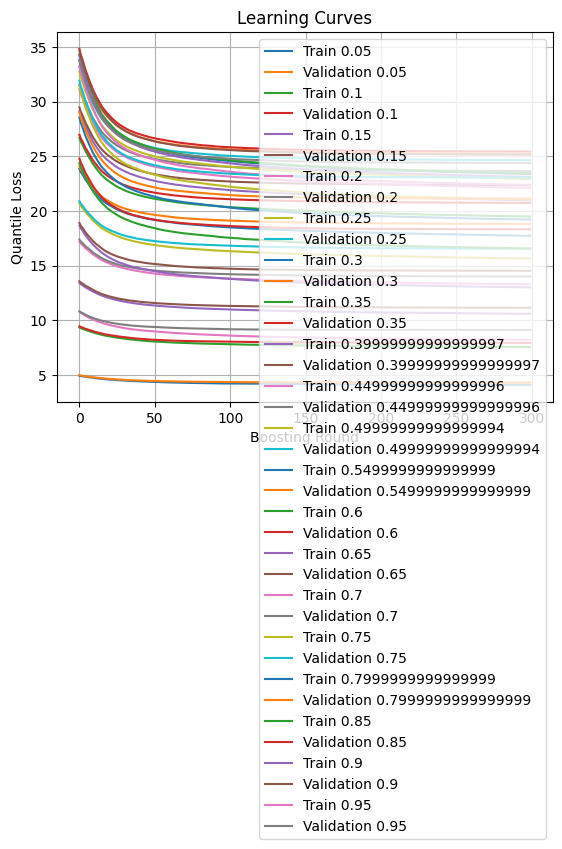

In [9]:
for quantile, evals_result in pricing_model.evals_results.items():
    train_loss = evals_result['train']['quantile']
    val_loss = evals_result['val']['quantile']
    plt.plot(train_loss, label=f'Train {quantile}')
    plt.plot(val_loss, label=f'Validation {quantile}')
    plt.xlabel("Boosting Round")
plt.ylabel("Quantile Loss")
plt.title("Learning Curves")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
train_predictions = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_train))
avg_loss_train, market_share_train = utils.metrics(train_predictions, y_train)
print(f"Training Metrics:")
print(f"Average Loss: {avg_loss_train:.2f}")
print(f"Market Share: {market_share_train:.2%}")

# Val prediction

# Calculate and print metrics for training set
val_predictions = pricing_model.base_models[0.7].predict(xgb.DMatrix(X_val))
avg_loss_val, market_share_val = utils.metrics(val_predictions, y_val)
print(f"Training Metrics:")
print(f"Average Loss: {avg_loss_val:.2f}")
print(f"Market Share: {market_share_val:.2%}")

Training Metrics:
Average Loss: 56.56
Market Share: 29.90%
Training Metrics:
Average Loss: 60.48
Market Share: 31.45%


In [11]:
# Function to get feature importance from a model
def get_feature_importance(model, feature_names):
    importance_scores = model.get_score(importance_type='gain')
    # Convert to DataFrame for easier manipulation
    importance_df = pd.DataFrame({
        'Feature': list(importance_scores.keys()),
        'Importance': list(importance_scores.values())
    })
    
    # Map F0, F1, etc. to actual feature names if needed
    if 'F0' in importance_df['Feature'].values:
        feature_map = {f'F{i}': name for i, name in enumerate(feature_names)}
        importance_df['Feature'] = importance_df['Feature'].map(lambda x: feature_map.get(x, x))
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    return importance_df

imp_df = get_feature_importance(pricing_model.base_models[0.7], X_train.columns)
imp_df.set_index('Feature', inplace=True)
correlation_df = X_train.copy()
correlation_df['target'] = y_train
correlation_df = correlation_df.corr()
correlation_to_target = correlation_df.target
imp_df = pd.concat([imp_df, correlation_to_target], axis=1)

In [12]:
imp_df

,Importance,target
vehicle_acquisition_time_OWNED,12.528727,-0.229564
driver_insured_years,6.986256,-0.226104
total_claims,5.978547,0.131497
driving_experience,5.128358,-0.252704
vehicle_acquisition_FIRST_HAND,4.548930,-0.047206
vehicle_use_PROFESSIONAL,3.440591,0.071875
vehicle_acquisition_time_RECENT,2.849394,0.221618
vehicle_age,2.759942,0.104236
driver_age,2.650629,-0.191563
driver_claims_last_1_year,2.216992,0.087518


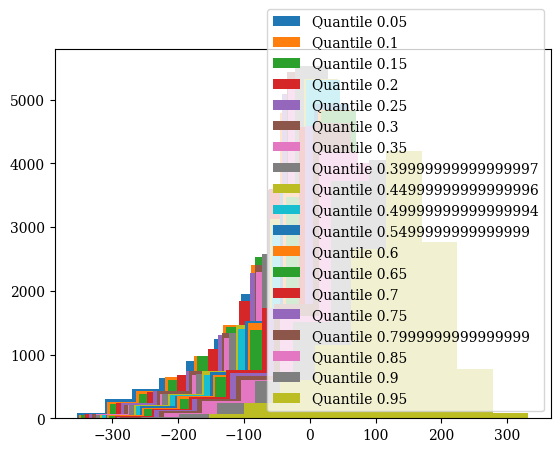

In [55]:
f, ax = plt.subplots(1, 1)

quantile_preds = {}


for quantile, model_ in pricing_model.base_models.items():
    preds = model_.predict(xgb.DMatrix(X_val))
    quantile_preds[quantile] = preds
    errors = preds - y_val
    ax.hist(errors, label=f'Quantile {quantile}')
ax.legend()

# Obtain PCA features to use them in selector model

The goal of the selector model is whether to decide to make an offer or not to the client. The hope is that we avoid high risk clients, where our error might be big with respect to the competition.

In [139]:
# Standardize the features

n_pca_components = 2

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
X_pca_train = X_pca[:, :n_pca_components]

X_scaled_val = scaler.transform(X_val)
X_pca_val = pca.transform(X_scaled_val)
X_pca_val = X_pca_val[:, :n_pca_components]

X_train_extend = X_train.copy()
X_val_extend = X_val.copy()

for i in range(n_pca_components):
    X_train_extend[f'PCA{i+1}'] = X_pca_train[:, i]
    X_val_extend[f'PCA{i+1}'] = X_pca_val[:, i]

X_train_extend.head()




,driver_insured_years,occasional_driver_license_attainment_age,policyholder_age,policyholder_license_attainment_age,vehicle_engine_power,vehicle_number_of_doors,driver_claims_last_1_year,driver_claims_from_year_1_to_2,driver_claims_from_year_2_to_3,driver_claims_from_year_3_to_4,...,vehicle_acquisition_time_BUYING,vehicle_acquisition_time_RECENT,vehicle_acquisition_FIRST_HAND,vehicle_acquisition_PRIVATE,total_claims,driver_other_vehicles_BIKE,driver_other_vehicles_CAR,driver_other_vehicles_OTHER,PCA1,PCA2
9433,8.0,20.0,46.0,19.0,100,5,0,0,0,0,...,0,0,0,1,0,0.0,1.0,0.0,0.602075,-0.731533
50781,7.0,20.0,46.0,19.0,230,5,0,0,0,0,...,1,0,0,0,0,0.0,0.0,1.0,-3.609469,2.412783
9313,6.0,20.0,46.0,19.0,150,5,0,0,0,0,...,0,1,0,0,0,0.0,1.0,0.0,-3.497903,-1.116452
52766,11.0,25.0,46.0,19.0,130,3,0,0,0,0,...,0,0,0,1,0,0.0,1.0,0.0,1.481471,1.267240
29933,7.0,20.0,46.0,19.0,115,5,0,0,0,0,...,0,0,0,1,0,0.0,1.0,0.0,0.891602,1.252672


In [21]:
def interp_pred(pricing_model_, X, quantile):
    
    """
    Interpolate between quantile predictions to get predictions for any quantile.
    
    Args:
        pricing_model_: The pricing model with trained base models
        X: Features to predict on
        quantile: The desired quantile (between 0 and 1)
        
    Returns:
        Interpolated predictions for the specified quantile
    """
    # Get the available quantiles from the model
    available_quantiles = sorted(pricing_model_.base_models.keys())
    
    # Handle edge cases
    if quantile <= min(available_quantiles):
        return pricing_model_.base_models[min(available_quantiles)].predict(xgb.DMatrix(X))
    
    if quantile >= max(available_quantiles):
        return pricing_model_.base_models[max(available_quantiles)].predict(xgb.DMatrix(X))
    
    # Find the two quantiles that sandwich the requested quantile
    lower_quantile = max([q for q in available_quantiles if q <= quantile])
    upper_quantile = min([q for q in available_quantiles if q >= quantile])
    
    # If we hit an exact quantile, just return that prediction
    if lower_quantile == upper_quantile:
        return pricing_model_.base_models[lower_quantile].predict(xgb.DMatrix(X))
    
    # Get predictions for the two quantiles
    lower_preds = pricing_model_.base_models[lower_quantile].predict(xgb.DMatrix(X))
    upper_preds = pricing_model_.base_models[upper_quantile].predict(xgb.DMatrix(X))
    
    # Linearly interpolate between the two predictions
    weight = (quantile - lower_quantile) / (upper_quantile - lower_quantile)
    interpolated_preds = lower_preds * (1 - weight) + upper_preds * weight
    
    return interpolated_preds

def interp_pred_from_precomputed(quantile_predictions, target_quantile):
    """
    Interpolate between precomputed quantile predictions to get predictions for any quantile.
    
    Args:
        quantile_predictions: Dictionary mapping quantiles to their predictions
        target_quantile: The desired quantile (between 0 and 1) to interpolate
        
    Returns:
        Interpolated predictions for the specified quantile
    """
    # Get the available quantiles
    available_quantiles = sorted(quantile_predictions.keys())
    
    # Handle edge cases
    if target_quantile <= min(available_quantiles):
        return quantile_predictions[min(available_quantiles)]
    
    if target_quantile >= max(available_quantiles):
        return quantile_predictions[max(available_quantiles)]
    
    # Find the two quantiles that sandwich the requested quantile
    lower_quantile = max([q for q in available_quantiles if q <= target_quantile])
    upper_quantile = min([q for q in available_quantiles if q >= target_quantile])
    
    # If we hit an exact quantile, just return that prediction
    if lower_quantile == upper_quantile:
        return quantile_predictions[lower_quantile]
    
    # Get predictions for the two quantiles
    lower_preds = quantile_predictions[lower_quantile]
    upper_preds = quantile_predictions[upper_quantile]
    
    # Linearly interpolate between the two predictions
    weight = (target_quantile - lower_quantile) / (upper_quantile - lower_quantile)
    interpolated_preds = lower_preds * (1 - weight) + upper_preds * weight
    
    return interpolated_preds

class MatrixInterpolator:
    """
    A class for efficiently interpolating values between dictionary keys using matrix operations.
    
    This interpolator handles large arrays (e.g., length 60000) efficiently by using
    vectorized operations instead of element-by-element loops.
    """
    
    def __init__(self, q_dict):
        """
        Initialize the interpolator with a dictionary of q values and corresponding arrays.
        
        Args:
            q_dict: Dictionary where keys are q values and values are numpy arrays
                   All arrays in the dictionary must have the same shape
        """
        # Convert dictionary to sorted arrays for faster lookup
        self.q_values = np.array(sorted(q_dict.keys()))
        self.arrays = np.array([q_dict[q] for q in self.q_values])
        
        # Validate that all arrays have the same shape
        if len(set(arr.shape for arr in self.arrays)) > 1:
            raise ValueError("All arrays in the dictionary must have the same shape")
    
    def interpolate(self, query_q):
        """
        Interpolate values for an array of query q values.
        
        Args:
            query_q: Numpy array of q values to interpolate at
            
        Returns:
            Numpy array of interpolated values with the same shape as arrays in the dictionary
        """
        # Ensure query_q is a numpy array
        query_q = np.asarray(query_q)
        
        # Find the index of the closest quantile for each query q
        # We use the absolute difference to find the closest match
        closest_indices = np.argmin(np.abs(self.q_values[:, np.newaxis] - query_q), axis=0)
        
        # Get the result by selecting the appropriate array for each query point
        # This creates a 1D array where each element is selected based on closest_indices
        result = np.array([self.arrays[idx, i] for i, idx in enumerate(closest_indices)])
        
        return result



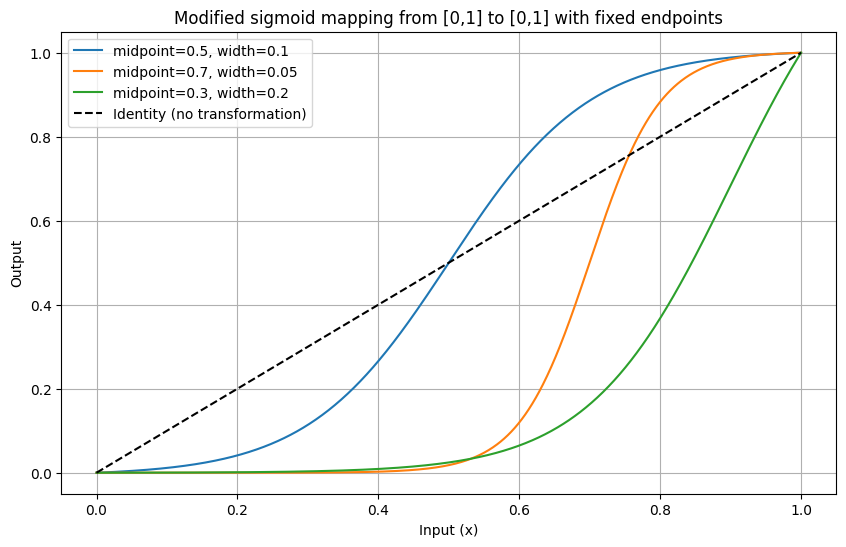

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

def sigmoid_01_mapping(x, midpoint=0.5, width=0.1):
    """
    Maps values from [0,1] to [0,1] using a modified sigmoid function
    that ensures endpoints map exactly to 0 and 1.
    
    Parameters:
    -----------
    x : array-like
        Input values in range [0,1]
    midpoint : float, default=0.5
        The x-value where the function equals 0.5
    width : float, default=0.1
        Controls the steepness of the curve. Smaller values create steeper transitions.
        
    Returns:
    --------
    array-like
        Transformed values in range [0,1] with f(0)=0 and f(1)=1
    """
    # Handle edge cases explicitly
    
    # Scale and shift to map [0,1] to appropriate sigmoid input range
    scaled_x = (x - midpoint) / width
    
    # Apply sigmoid
    sigmoid_values = expit(scaled_x)
    
    # Normalize to ensure output maps [0,1] to [0,1]
    # Calculate what sigmoid would give at endpoints
    sigmoid_0 = expit((0 - midpoint) / width)
    sigmoid_1 = expit((1 - midpoint) / width)
    
    # Apply normalization
    result = (sigmoid_values - sigmoid_0) / (sigmoid_1 - sigmoid_0)

    return result

# Demonstration
x = np.linspace(0, 1, 1000)

# Plot with different parameters
plt.figure(figsize=(10, 6))

plt.plot(x, sigmoid_01_mapping(x, midpoint=0.5, width=0.1), label='midpoint=0.5, width=0.1')
plt.plot(x, sigmoid_01_mapping(x, midpoint=0.7, width=0.05), label='midpoint=0.7, width=0.05')
plt.plot(x, sigmoid_01_mapping(x, midpoint=0.9, width=0.1), label='midpoint=0.3, width=0.2')
plt.plot(x, x, 'k--', label='Identity (no transformation)')

plt.xlabel('Input (x)')
plt.ylabel('Output')
plt.title('Modified sigmoid mapping from [0,1] to [0,1] with fixed endpoints')
plt.legend()
plt.grid(True)
plt.show()


In [25]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np

PARAMETER_NAMES = [ "pred_quantile",
                    "upper_quantile",
                    "lower_quantile", 
                    "spread_switch"]

class PricingOptimizationProblem(Problem):
    def __init__(self, pricing_model, X_train, y_train):
        super().__init__(n_var=6, n_obj=2, n_constr=0,
                          xl=np.array([0.05, 0.05, 0.05, -0.1,  0.1, 0]),
                          xu=np.array([0.95, 0.95, 0.95, 0.1, 0.8, 0.1]))
        self.pricing_model = pricing_model
        self.X_train = X_train
        self.y_train = y_train
        

        self.predictions = {q: self.pricing_model.base_models[q].predict(xgb.DMatrix(X_train))
                             for q in self.pricing_model.base_models.keys()}
        self.matrix_interpolator = MatrixInterpolator(self.predictions)
        
    def _evaluate(self, x, out, *args, **kwargs):
        # Extract parameters
        f_values = np.zeros((len(x), 2))  # Two objectives: avg_loss and -market_share
        
        for i, params in enumerate(x):
            (
            pred_quantile,
            upper_quantile,
            lower_quantile,
            prop_pred_quantile,
            spread_norm_mean,
            spread_norm_width
            ) = params

            upper_prices = interp_pred_from_precomputed(self.predictions, upper_quantile)
            lower_prices = interp_pred_from_precomputed(self.predictions, lower_quantile)

            spread = upper_prices - lower_prices
            # Handle division by zero by checking if spread.max() is zero
            if spread.max() > 0:
                spread_norm = spread/spread.max()
            else:
                spread_norm = np.zeros_like(spread)

            success_probabilities = sigmoid_01_mapping(spread_norm, midpoint=spread_norm_mean,
                                                       width=spread_norm_width)
            
            success_probabilities = np.clip(success_probabilities, 0.05, 0.95)
            
            quantiles_to_interpolate = pred_quantile + prop_pred_quantile*spread_norm
            quantiles_to_interpolate = np.clip(quantiles_to_interpolate, 0.05, 0.95)
            adjusted_prices = self.matrix_interpolator.interpolate(quantiles_to_interpolate)

            # Generate Bernoulli trials based on these probabilities
            bernoulli_trials = np.random.binomial(n=1, p=success_probabilities)
            adjusted_prices = adjusted_prices + 1e6*(bernoulli_trials == 1)
            
            # Calculate metrics
            avg_loss, market_share = utils.metrics(adjusted_prices, self.y_train)
            
            if market_share == 0:
                f_values[i, 0] = 1e6  # Large penalty for no sales
                f_values[i, 1] = 1.0  # Worst market share (0%)
            else:
                f_values[i, 0] = avg_loss
                f_values[i, 1] = -market_share  # Negative because we want to maximize market share
        
        out["F"] = f_values


In [26]:
# Create problem
problem = PricingOptimizationProblem(pricing_model, X_train, y_train)

# Configure algorithm
algorithm = NSGA2(
    pop_size=200,
    eliminate_duplicates=True
)

# Run optimization
res = minimize(problem,
                algorithm,
                ('n_gen', 50),
                seed=1,
                verbose=True)

    

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     27 |             - |             -
     2 |      200 |     35 |  0.0507616401 |         ideal
     3 |      300 |     49 |  0.0099256092 |             f
     4 |      400 |     55 |  0.1166811197 |         ideal
     5 |      500 |     60 |  0.0065102683 |             f
     6 |      600 |     68 |  0.0061075744 |             f
     7 |      700 |     74 |  0.0041838578 |             f
     8 |      800 |     86 |  0.0042717628 |             f
     9 |      900 |     99 |  0.0028732978 |             f
    10 |     1000 |    100 |  0.0030757296 |             f
    11 |     1100 |    100 |  0.0025537058 |             f
    12 |     1200 |    100 |  0.0239719381 |         ideal
    13 |     1300 |    100 |  0.0028420937 |             f
    14 |     1400 |    100 |  0.0018403054 |             f
    15 |     1500 |    100 |  0.0051254283 |             f
    16 |     1600 |    100 |  0.0018478361 |            

In [27]:
avg_losses_opti = res.F[:, 0]
market_shares_opti = res.F[:, 1]

idx_30pct = np.argmin(np.abs(market_shares_opti + 0.3))
avg_loss_30pct = avg_losses_opti[idx_30pct]
market_share_30pct = -market_shares_opti[idx_30pct]

print(f"Solution with market share just above 30%:")
print(f"Market Share = {market_share_30pct:.2%}")
print(f"Average Loss = {avg_loss_30pct:.2f}")
print("Parameters:")
print(res.X[idx_30pct])

Solution with market share just above 30%:
Market Share = 29.88%
Average Loss = 42.05
Parameters:
[ 0.05760965  0.37354223  0.71395901 -0.05081602  0.78661188  0.004286  ]


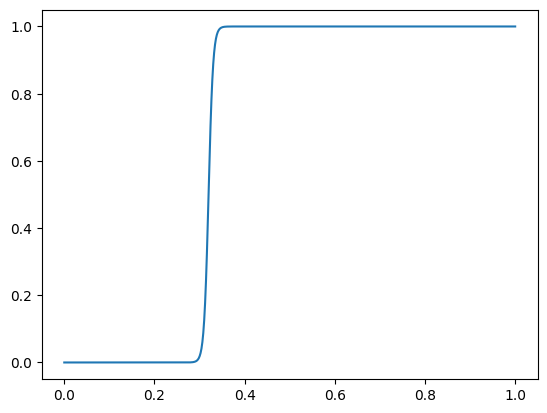

In [17]:
xarray = np.linspace(0, 1, 1000)
yarray = sigmoid_01_mapping(xarray, midpoint=0.32, width=0.005)

plt.plot(xarray, yarray)
plt.show()

In [28]:
from pymoo.visualization.scatter import Scatter

Scatter().add(res.F).show()

# Evaluate solutions on validation set
validation_problem = PricingOptimizationProblem(pricing_model, X_val, y_val)
val_f_values = np.zeros((len(res.X), 2))
out_val = {"F": val_f_values}
validation_problem._evaluate(res.X, out_val)

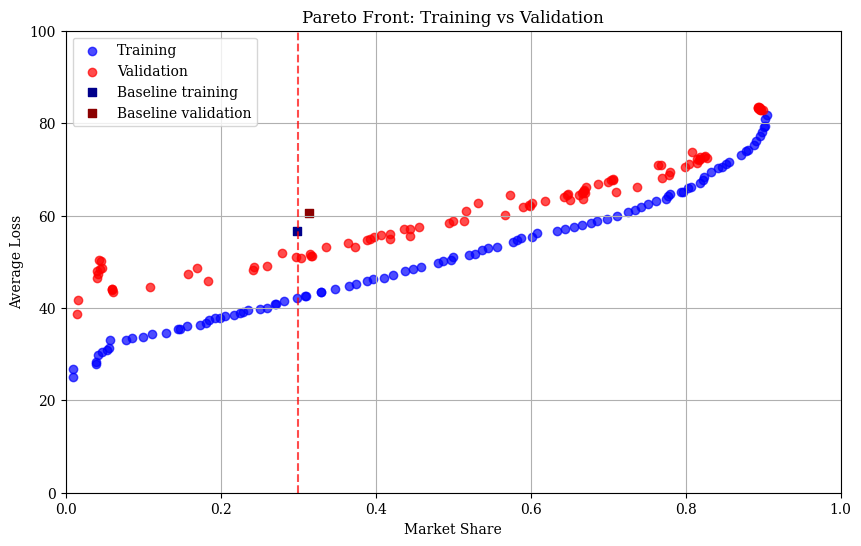

In [29]:
# Plot Pareto fronts for both training and validation
plt.figure(figsize=(10, 6))
plt.scatter(-res.F[:, 1], res.F[:, 0], label='Training', alpha=0.7, color='blue')
plt.scatter(-out_val["F"][:, 1], out_val["F"][:, 0], label='Validation', alpha=0.7, color='red')
plt.xlabel('Market Share')
plt.ylabel('Average Loss')
plt.title('Pareto Front: Training vs Validation')
plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7)
plt.scatter(market_share_train, avg_loss_train, color='darkblue', label='Baseline training', marker='s')
plt.scatter(market_share_val, avg_loss_val, color='darkred', label='Baseline validation', marker='s')
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.show()

# Working example

In [33]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
import numpy as np

PARAMETER_NAMES = [ "pred_quantile",
                    "upper_quantile",
                    "lower_quantile", 
                    "spread_switch"]

class PricingOptimizationProblem(Problem):
    def __init__(self, pricing_model, X_train, y_train):
        super().__init__(n_var=4, n_obj=2, n_constr=0,
                          xl=np.array([0.05, 0.05, 0.05, -3]),
                          xu=np.array([0.95, 0.95, 0.95, 3]))
        self.pricing_model = pricing_model
        self.X_train = X_train
        self.y_train = y_train

        self.predictions = {q: self.pricing_model.base_models[q].predict(xgb.DMatrix(self.X_train))
                             for q in self.pricing_model.base_models.keys()}
       
        
    def _evaluate(self, x, out, *args, **kwargs):
        # Extract parameters
        f_values = np.zeros((len(x), 2))  # Two objectives: avg_loss and -market_share
        
        for i, params in enumerate(x):
            (
            pred_quantile,
            upper_quantile,
            lower_quantile,
            upper_spread_switch,
            #lower_spread_switch
            ) = params
            
            adjusted_prices = interp_pred_from_precomputed(self.predictions, pred_quantile)
            upper_prices = interp_pred_from_precomputed(self.predictions, upper_quantile)
            lower_prices = interp_pred_from_precomputed(self.predictions, lower_quantile)
            spread = upper_prices - lower_prices
            spread_norm = (spread - spread.mean())/spread.std()
            adjusted_prices = adjusted_prices +  1e6*(spread_norm > upper_spread_switch)
            #adjusted_prices = adjusted_prices +  1e6*(spread_norm < lower_spread_switch)
            
            # Calculate metrics
            avg_loss, market_share = utils.metrics(adjusted_prices, self.y_train)
            
            if market_share == 0:
                f_values[i, 0] = 1e6  # Large penalty for no sales
                f_values[i, 1] = 1.0  # Worst market share (0%)
            else:
                f_values[i, 0] = avg_loss
                f_values[i, 1] = -market_share  # Negative because we want to maximize market share
        
        out["F"] = f_values


In [34]:
# Create problem
problem = PricingOptimizationProblem(pricing_model, pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Configure algorithm
algorithm = NSGA2(
    pop_size=200,
    eliminate_duplicates=True
)

# Run optimization
res = minimize(problem,
                algorithm,
                ('n_gen', 100),
                seed=1,
                verbose=True)

    

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     26 |             - |             -
     2 |      400 |     37 |  0.0124936105 |             f
     3 |      600 |     59 |  0.0077943434 |             f
     4 |      800 |     78 |  0.0049139719 |             f
     5 |     1000 |    104 |  0.0065456760 |         ideal
     6 |     1200 |    133 |  0.0035339272 |             f
     7 |     1400 |    157 |  0.0029007505 |         ideal
     8 |     1600 |    177 |  0.0016771931 |             f
     9 |     1800 |    200 |  0.0033205809 |             f
    10 |     2000 |    200 |  0.0015864322 |             f
    11 |     2200 |    200 |  0.0027475166 |             f
    12 |     2400 |    200 |  0.0050935729 |         ideal
    13 |     2600 |    200 |  0.0008867331 |             f
    14 |     2800 |    200 |  0.0016222391 |             f
    15 |     3000 |    200 |  0.0020412864 |             f
    16 |     3200 |    200 |  0.0023720625 |            

In [38]:
avg_losses_opti = res.F[:, 0]
market_shares_opti = res.F[:, 1]

idx_30pct = np.argmin(np.abs(market_shares_opti + 0.32))
avg_loss_30pct = avg_losses_opti[idx_30pct]
market_share_30pct = -market_shares_opti[idx_30pct]

print(f"Solution with market share just above 30%:")
print(f"Market Share = {market_share_30pct:.2%}")
print(f"Average Loss = {avg_loss_30pct:.2f}")
print("Parameters:")
param_names = ["pred_quantile", "upper_quantile", "lower_quantile", "upper_spread_switch", "lower_spread_switch"]
for name, value in zip(param_names, res.X[idx_30pct]):
    print(f"  {name} = {value:.4f}")


Solution with market share just above 30%:
Market Share = 32.11%
Average Loss = 42.53
Parameters:
  pred_quantile = 0.1377
  upper_quantile = 0.7335
  lower_quantile = 0.1202
  upper_spread_switch = -0.4762


In [36]:
from pymoo.visualization.scatter import Scatter

Scatter().add(res.F).show()

# Evaluate solutions on validation set
validation_problem = PricingOptimizationProblem(pricing_model, X_val, y_val)
val_f_values = np.zeros((len(res.X), 2))
out_val = {"F": val_f_values}
validation_problem._evaluate(res.X, out_val)


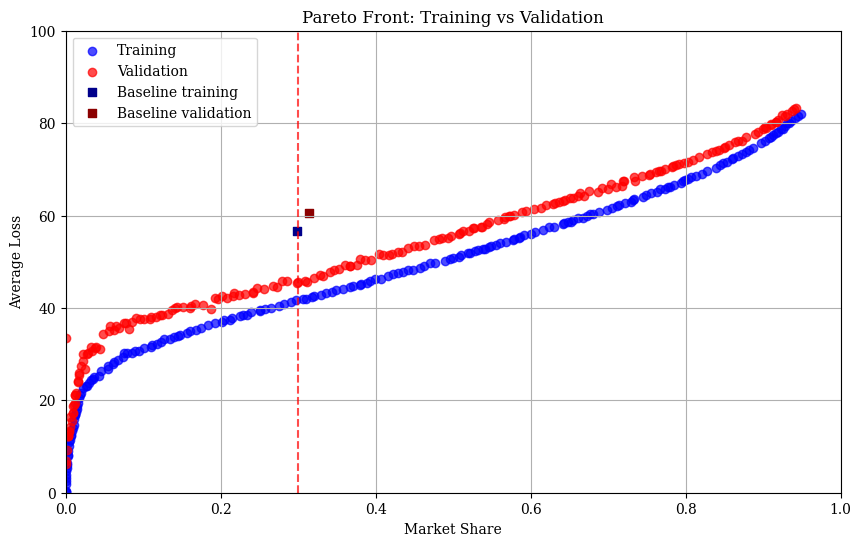

In [37]:
# Plot Pareto fronts for both training and validation
plt.figure(figsize=(10, 6))
plt.scatter(-res.F[:, 1], res.F[:, 0], label='Training', alpha=0.7, color='blue')
plt.scatter(-out_val["F"][:, 1], out_val["F"][:, 0], label='Validation', alpha=0.7, color='red')
plt.xlabel('Market Share')
plt.ylabel('Average Loss')
plt.title('Pareto Front: Training vs Validation')
plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7)
plt.scatter(market_share_train, avg_loss_train, color='darkblue', label='Baseline training', marker='s')
plt.scatter(market_share_val, avg_loss_val, color='darkred', label='Baseline validation', marker='s')
plt.ylim(0, 100)
plt.xlim(0, 1)
plt.legend()
plt.grid(True)
plt.show()


# Build pricing model and then other model to predict errors

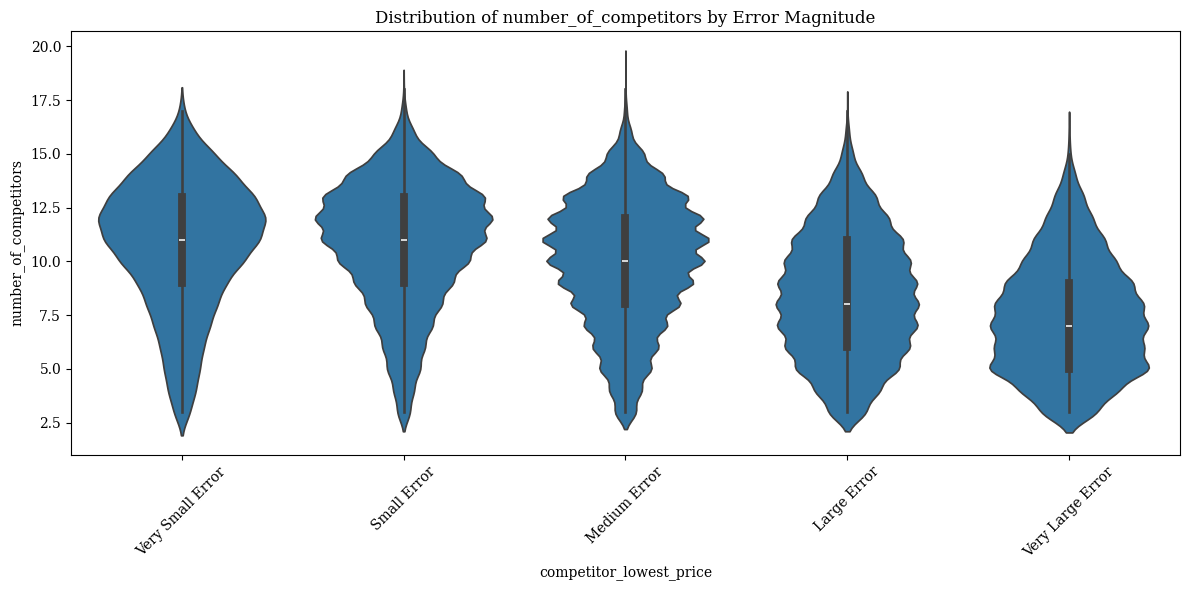


Statistics for number_of_competitors:
                           count       mean       std  min  25%   50%   75%  \
competitor_lowest_price                                                       
Very Small Error          5016.0  10.740032  3.011278  3.0  9.0  11.0  13.0   
Small Error              10032.0  10.802333  2.864240  3.0  9.0  11.0  13.0   
Medium Error             20063.0   9.970742  2.916645  3.0  8.0  10.0  12.0   
Large Error              10032.0   8.407197  2.861151  3.0  6.0   8.0  11.0   
Very Large Error          5016.0   7.428429  2.641124  3.0  5.0   7.0   9.0   

                          max  
competitor_lowest_price        
Very Small Error         17.0  
Small Error              18.0  
Medium Error             19.0  
Large Error              17.0  
Very Large Error         16.0  


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


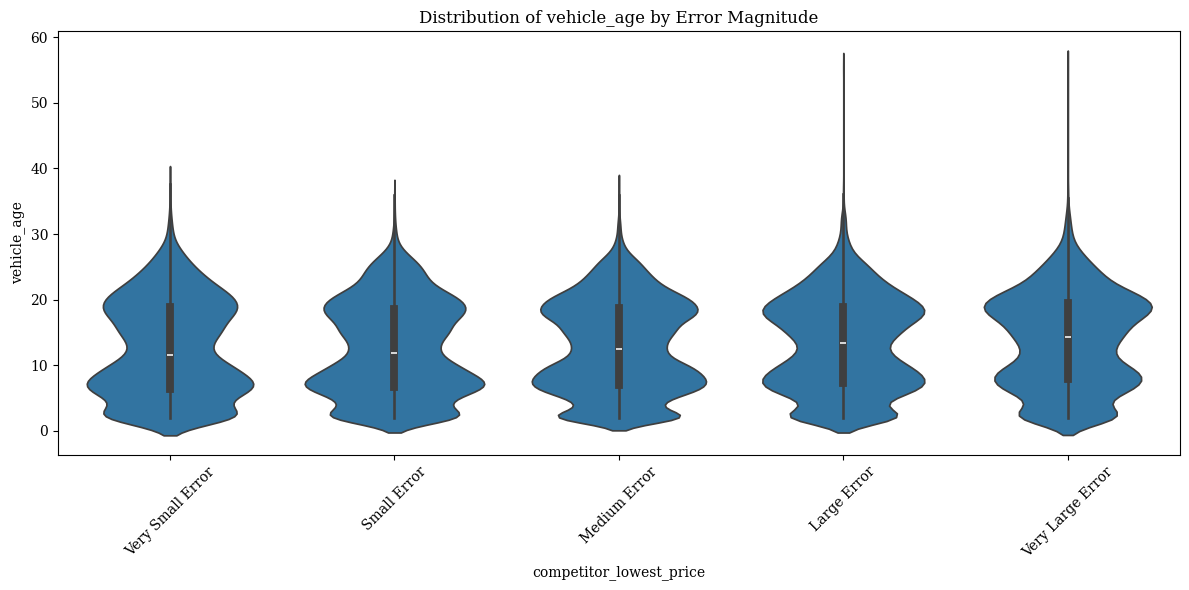


Statistics for vehicle_age:
                           count       mean       std       min       25%  \
competitor_lowest_price                                                     
Very Small Error          5016.0  12.550339  7.389951  2.001369  6.329911   
Small Error              10032.0  12.531910  7.123169  2.001369  6.663929   
Medium Error             20063.0  12.923992  6.989850  2.001369  7.000684   
Large Error              10032.0  13.311949  7.137723  2.001369  7.329227   
Very Large Error          5016.0  13.780212  7.231080  2.001369  7.832991   

                               50%        75%        max  
competitor_lowest_price                                   
Very Small Error         11.581109  18.915811  37.664613  
Small Error              11.832991  18.496920  36.000000  
Medium Error             12.495551  18.748802  37.081451  
Large Error              13.415469  18.915811  55.329227  
Very Large Error         14.245038  19.414100  55.329227  


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


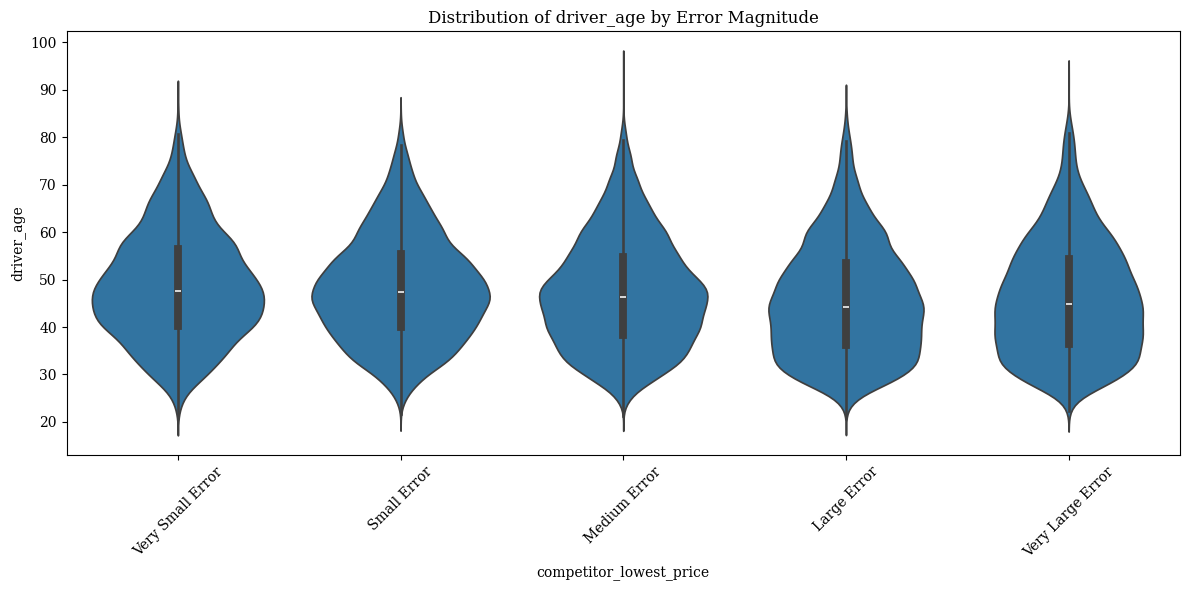


Statistics for driver_age:
                           count       mean        std        min        25%  \
competitor_lowest_price                                                        
Very Small Error          5016.0  48.617024  11.455566  21.333333  40.294319   
Small Error              10032.0  48.179692  11.138878  21.675565  39.906913   
Medium Error             20063.0  47.199968  11.560175  21.300479  38.388775   
Large Error              10032.0  45.583438  11.877124  20.982888  36.145106   
Very Large Error          5016.0  46.118557  12.118266  22.373717  36.463381   

                               50%        75%        max  
competitor_lowest_price                                   
Very Small Error         47.633128  56.438741  87.767283  
Small Error              47.303217  55.329227  84.925394  
Medium Error             46.239562  54.856947  95.104723  
Large Error              44.328542  53.433265  87.329227  
Very Large Error         44.792608  54.295003  91.805613 

/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


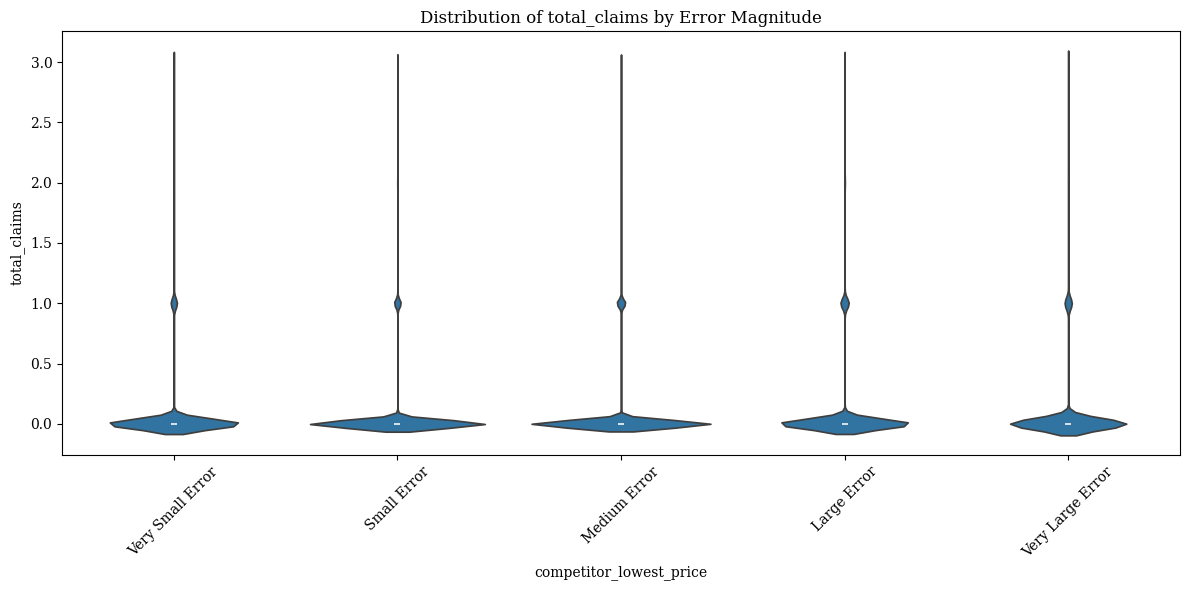


Statistics for total_claims:
                           count      mean       std  min  25%  50%  75%  max
competitor_lowest_price                                                      
Very Small Error          5016.0  0.049641  0.231446  0.0  0.0  0.0  0.0  3.0
Small Error              10032.0  0.039673  0.204186  0.0  0.0  0.0  0.0  3.0
Medium Error             20063.0  0.049444  0.227129  0.0  0.0  0.0  0.0  3.0
Large Error              10032.0  0.065989  0.263848  0.0  0.0  0.0  0.0  3.0
Very Large Error          5016.0  0.064793  0.261121  0.0  0.0  0.0  0.0  3.0


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


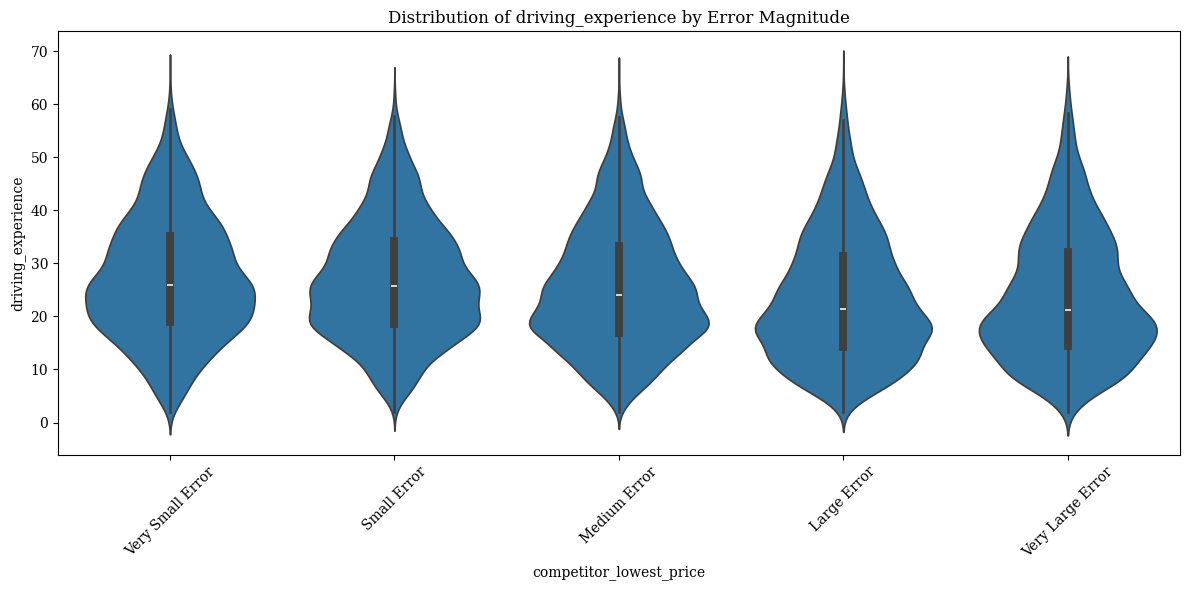


Statistics for driving_experience:
                           count       mean        std       min        25%  \
competitor_lowest_price                                                       
Very Small Error          5016.0  27.207589  11.561756  2.001369  18.915811   
Small Error              10032.0  26.765947  11.187298  2.001369  18.496920   
Medium Error             20063.0  25.449394  11.599285  2.001369  16.914442   
Large Error              10032.0  23.379169  11.857497  2.001369  14.245038   
Very Large Error          5016.0  23.646559  12.119443  2.001369  14.414784   

                               50%        75%        max  
competitor_lowest_price                                   
Very Small Error         26.001369  35.167693  65.166324  
Small Error              25.664613  34.168378  63.414100  
Medium Error             24.000000  33.245722  65.582478  
Large Error              21.330595  31.329227  66.329911  
Very Large Error         21.166324  32.082136  64.580424

/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


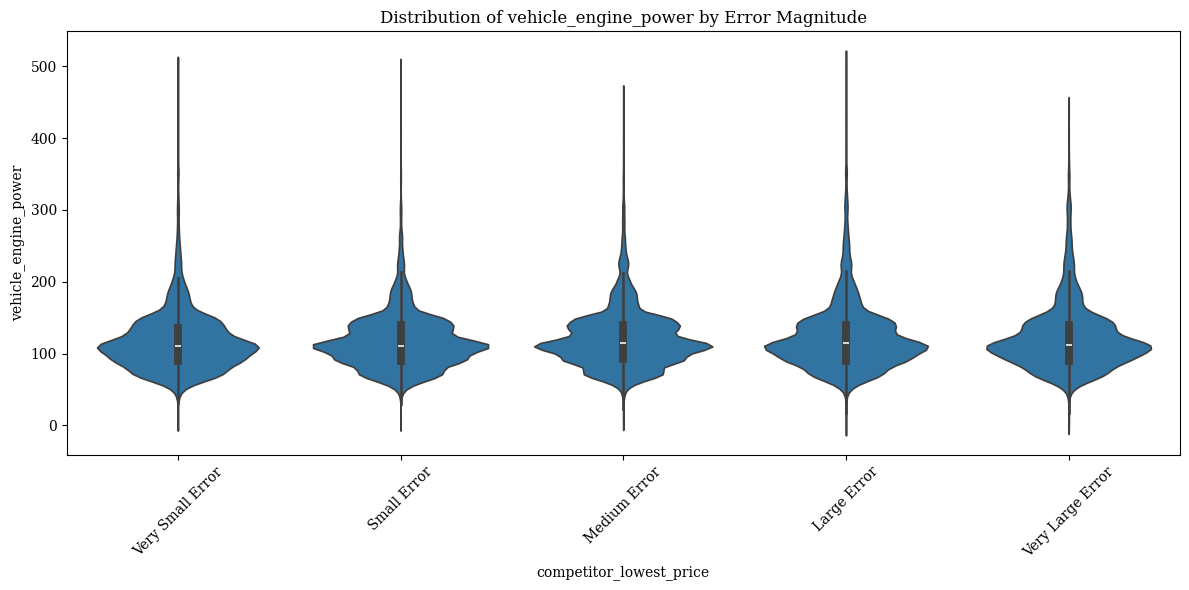


Statistics for vehicle_engine_power:
                           count        mean        std  min   25%    50%  \
competitor_lowest_price                                                     
Very Small Error          5016.0  117.130183  42.041474  8.0  90.0  110.0   
Small Error              10032.0  117.642644  39.049159  5.0  90.0  110.0   
Medium Error             20063.0  121.450232  41.749343  5.0  92.0  115.0   
Large Error              10032.0  123.464514  47.106951  1.0  90.0  114.0   
Very Large Error          5016.0  122.969298  46.830960  5.0  90.0  112.0   

                           75%    max  
competitor_lowest_price                
Very Small Error         136.0  498.0  
Small Error              140.0  498.0  
Medium Error             140.0  462.0  
Large Error              140.0  507.0  
Very Large Error         140.0  440.0  


/var/folders/7x/qgn219m96711nt4bv8k3tgtr0000gn/T/ipykernel_59173/750278562.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(X.groupby(error_cats)[feature_name].describe())


In [47]:


# Create error categories
error_quantiles = np.percentile(errors, [10, 30, 70, 90])
error_categories = pd.cut(errors, 
                         bins=[-np.inf, error_quantiles[0], error_quantiles[1], error_quantiles[2], error_quantiles[3], np.inf],
                         labels=["Very Small Error", 'Small Error', 'Medium Error', 'Large Error', 'Very Large Error'])

# Function to analyze feature distributions across error categories
def analyze_feature_by_errors(feature_name, X, error_cats):
    plt.figure(figsize=(12, 6))
    
    # Create violin plot
    sns.violinplot(data=X, x=error_cats, y=feature_name)
    plt.title(f'Distribution of {feature_name} by Error Magnitude')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\nStatistics for {feature_name}:")
    print(X.groupby(error_cats)[feature_name].describe())

# Analyze important features
important_features = [
    'number_of_competitors',
    'vehicle_age',
    'driver_age',
    'total_claims',
    'driving_experience',
    'vehicle_engine_power'
]

for feature in important_features:
    if feature in X_train.columns:
        analyze_feature_by_errors(feature, X_train, error_categories)

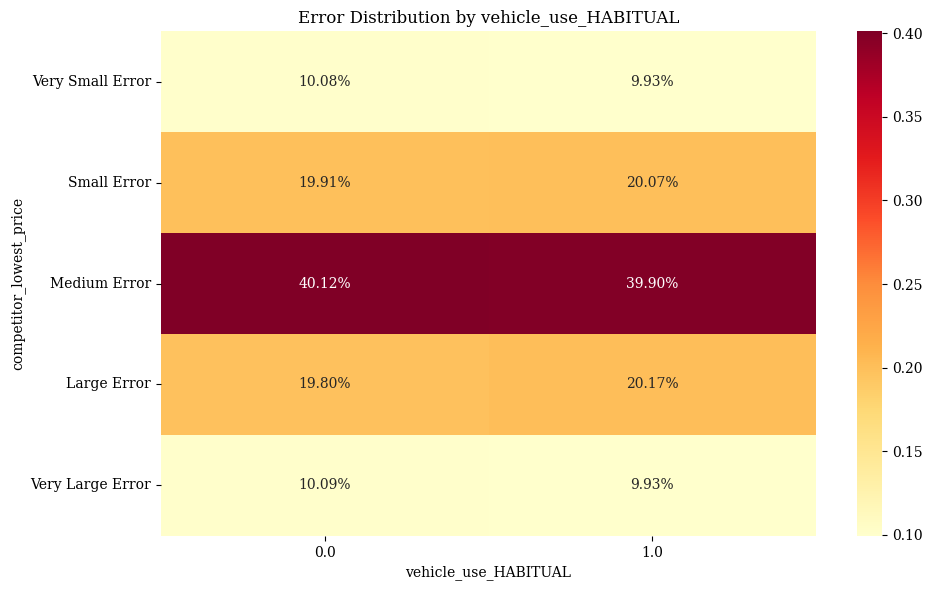

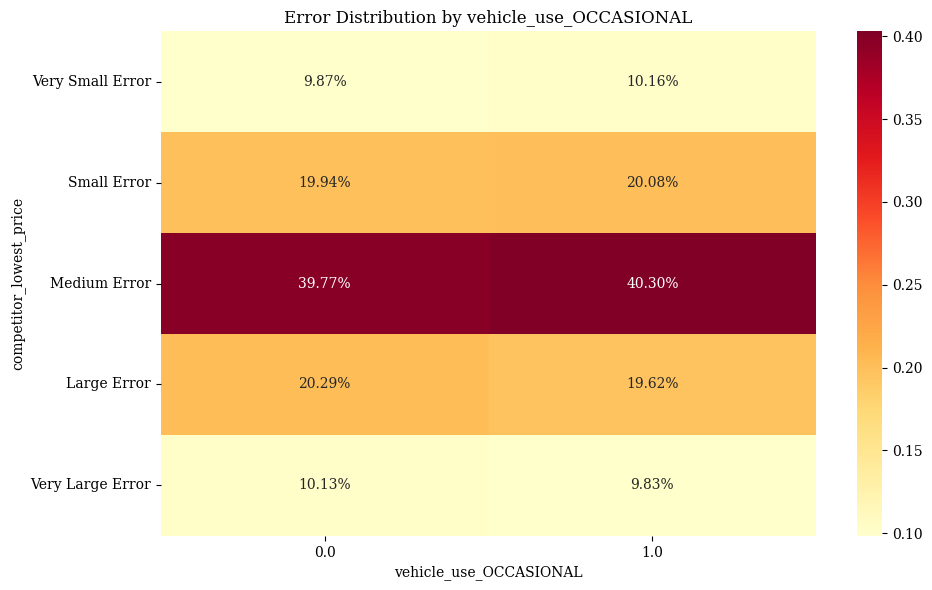

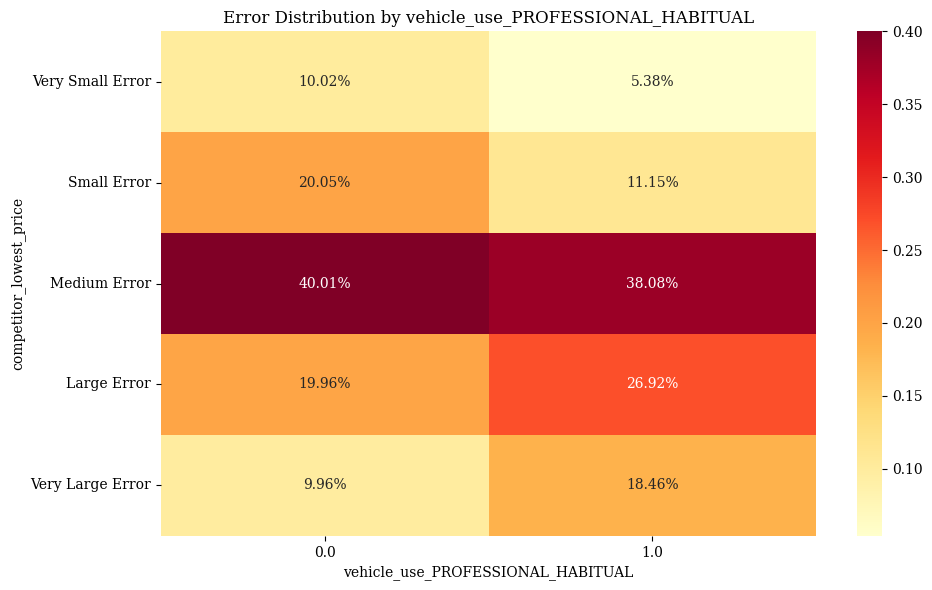

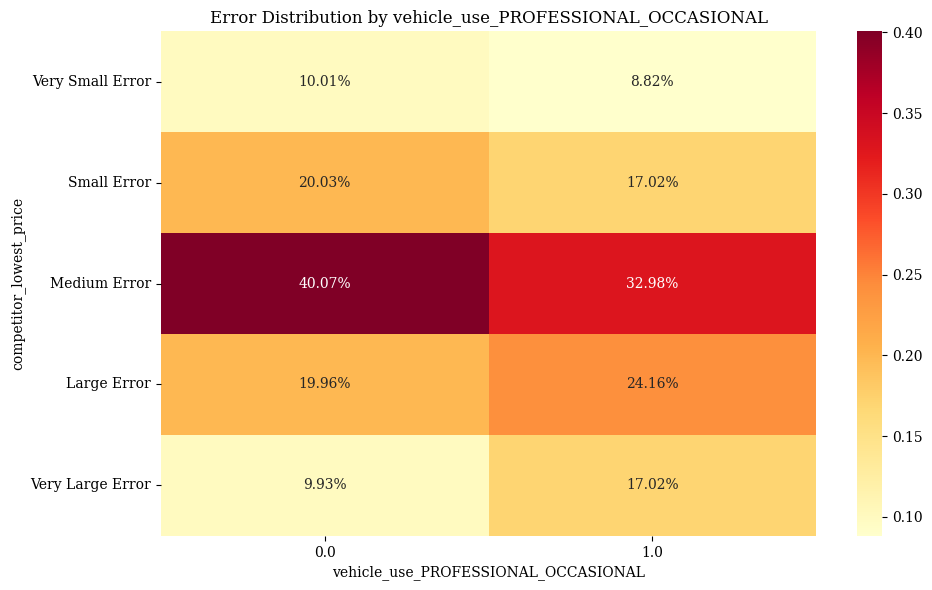

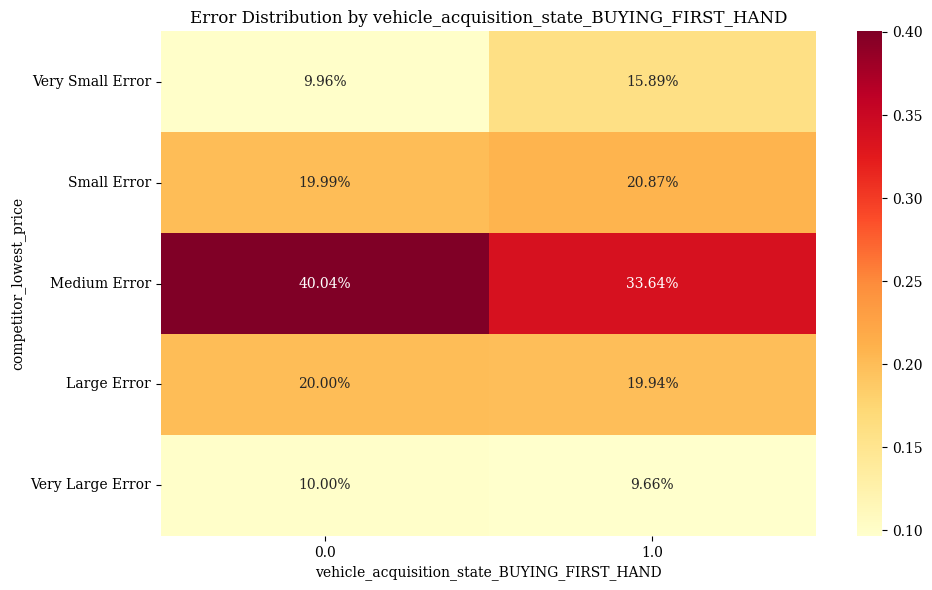

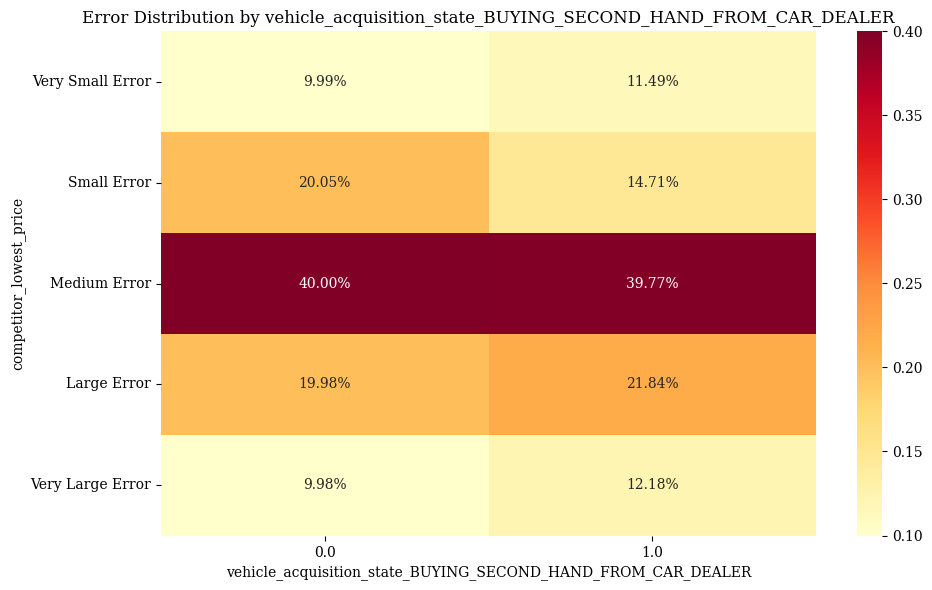

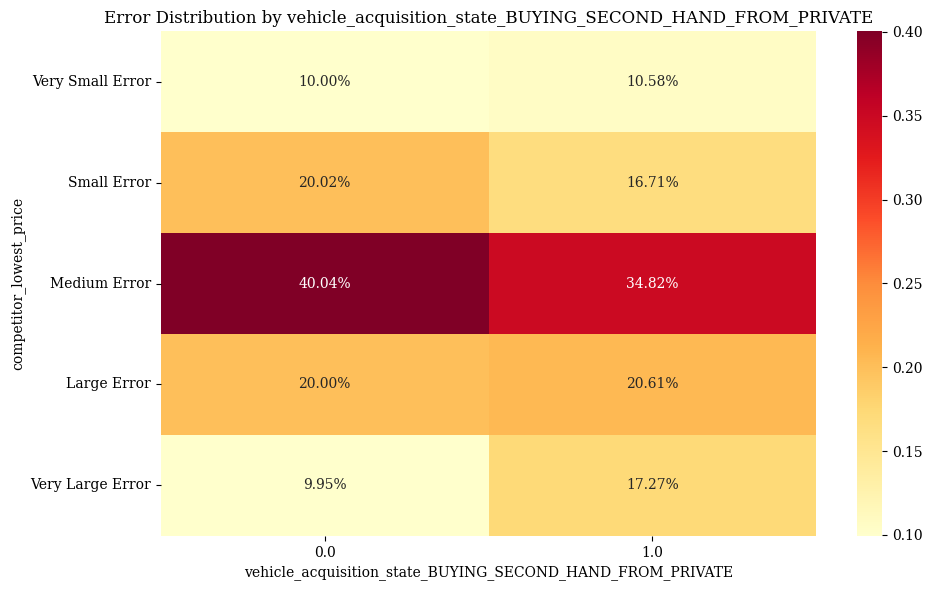

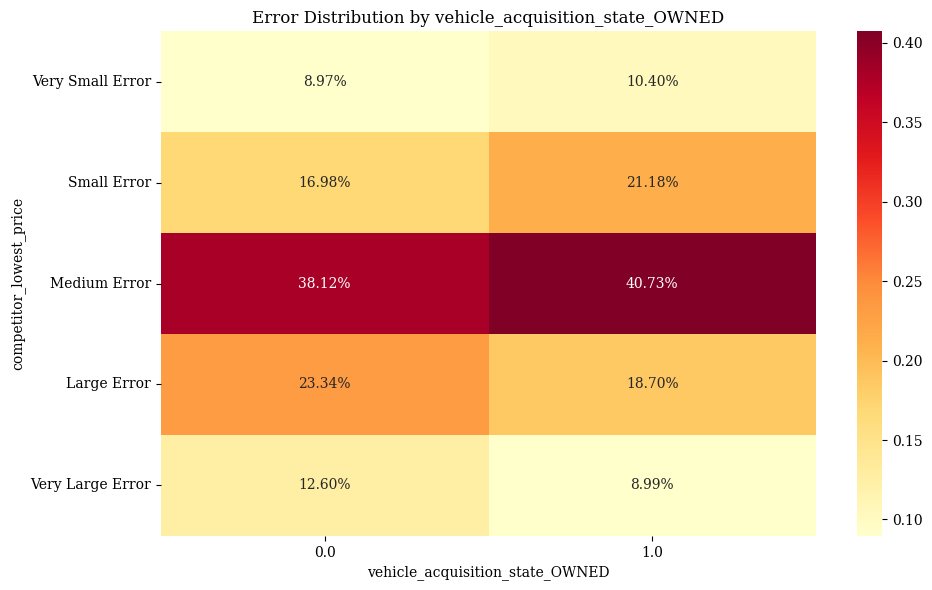

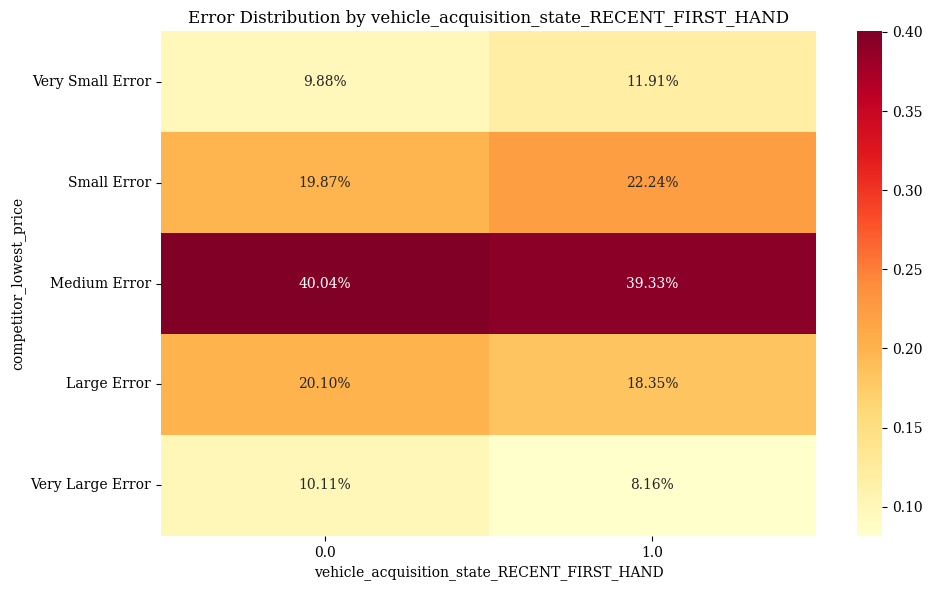

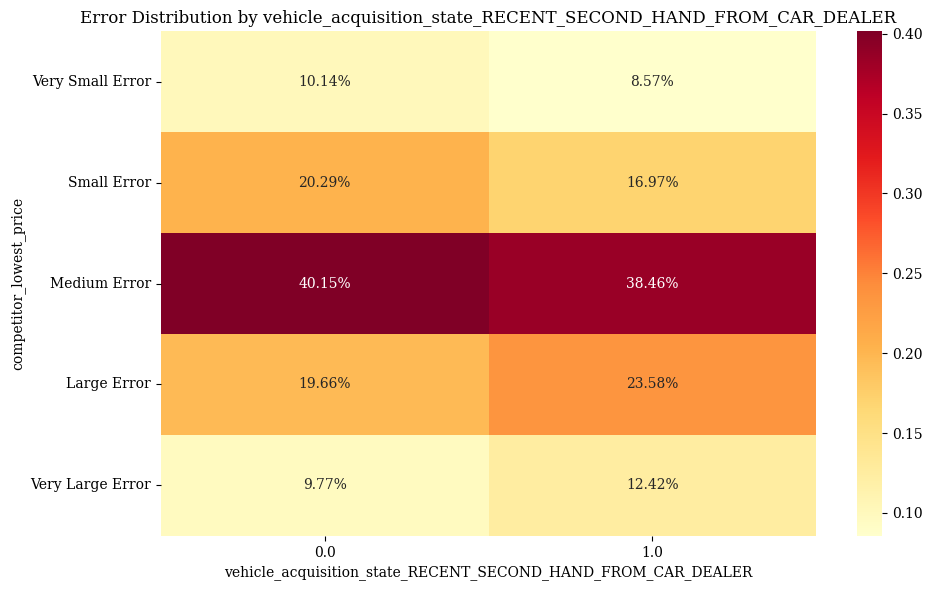

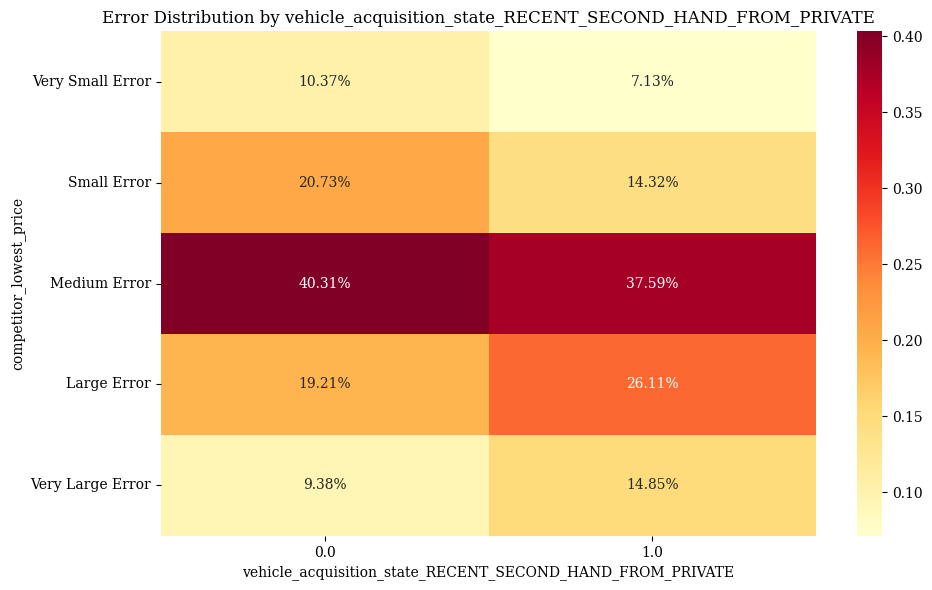

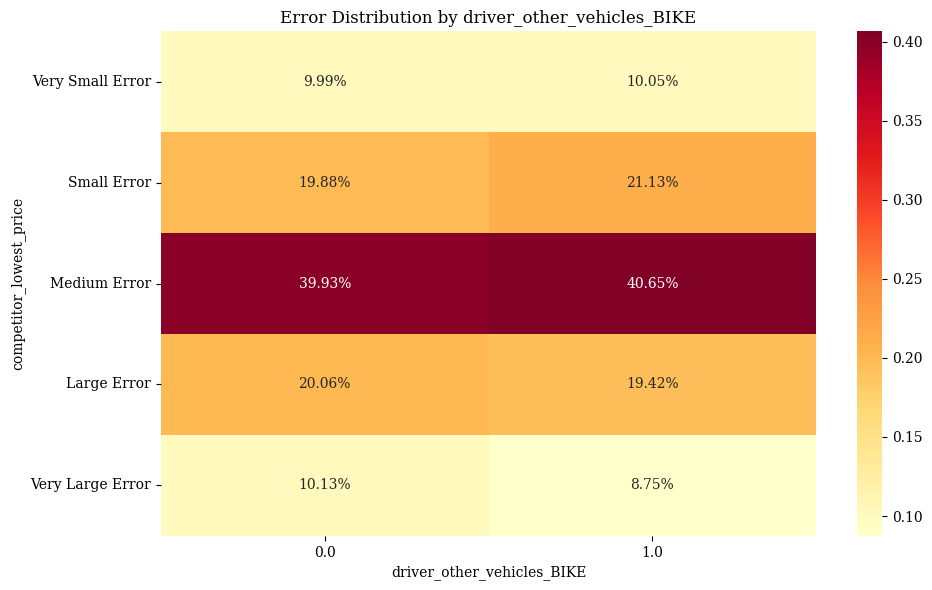

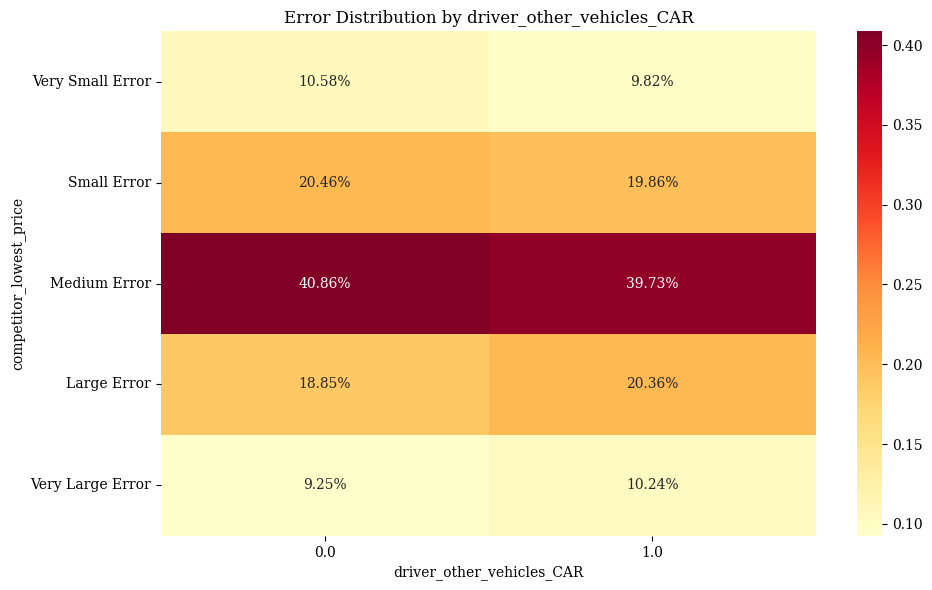

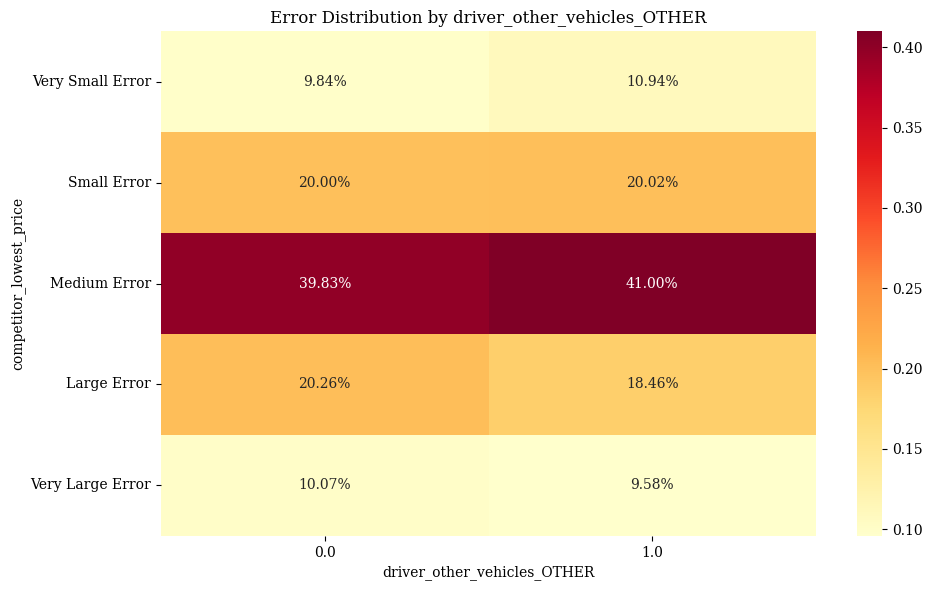

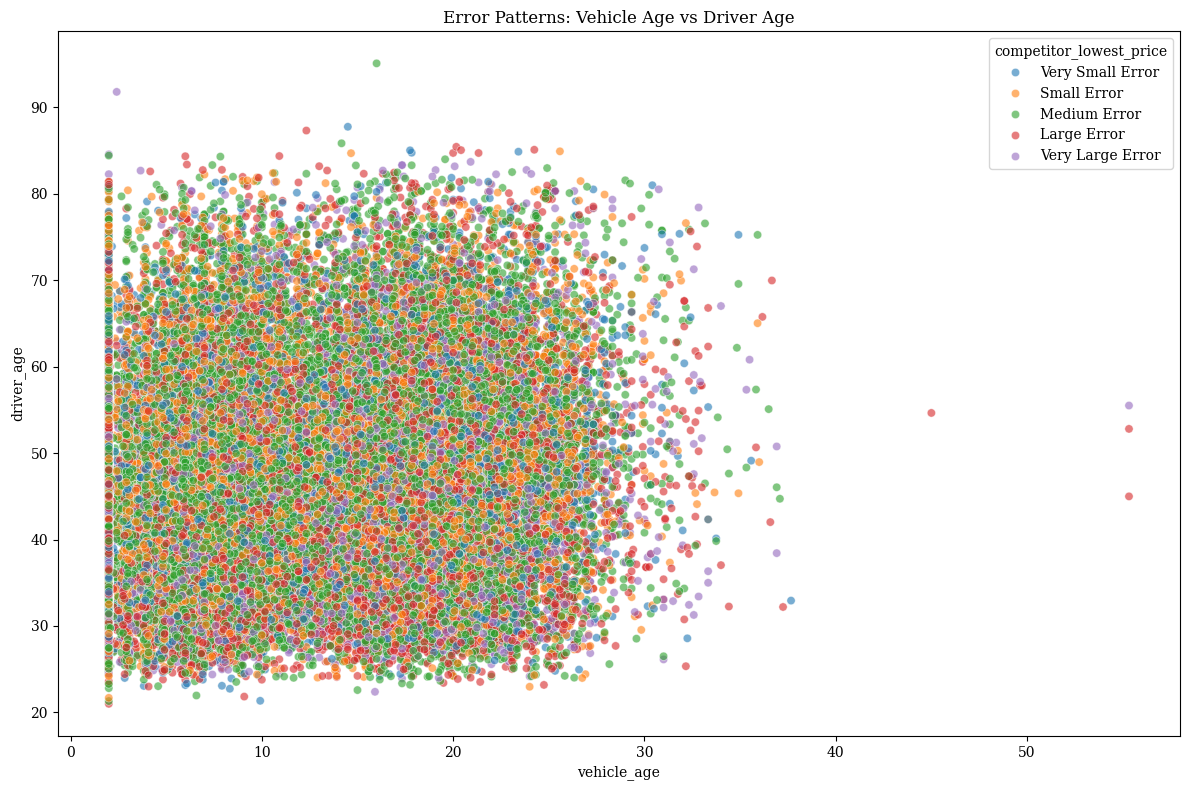

[0]	train-quantile:20.30522	val-quantile:34.84056
[100]	train-quantile:4.52116	val-quantile:19.91545
[199]	train-quantile:3.75316	val-quantile:19.62725
[0]	train-quantile:25.69789	val-quantile:33.06378
[100]	train-quantile:12.13086	val-quantile:20.37354
[199]	train-quantile:11.32718	val-quantile:20.22842
[0]	train-quantile:33.88990	val-quantile:37.95488
[100]	train-quantile:23.98781	val-quantile:28.26687
[199]	train-quantile:21.72573	val-quantile:27.85765


<Figure size 1200x800 with 0 Axes>

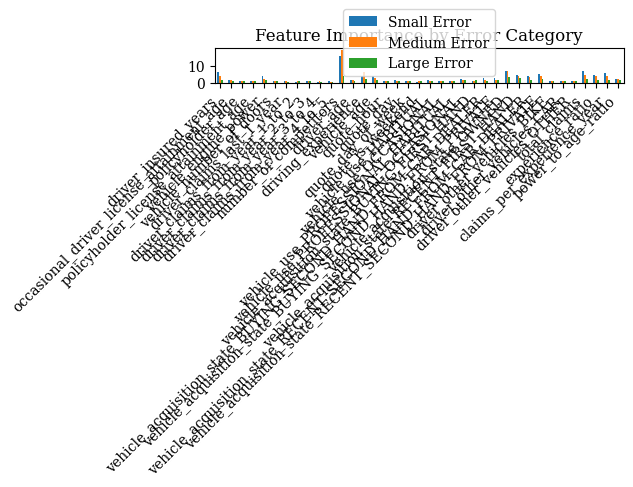

In [50]:
# Create error heatmap for categorical features

categorical_features = [col for col in X_train.columns if 
                       any(var in col for var in ["driver_other_vehicles", "vehicle_acquisition_state", "vehicle_use"])]

for cat_feature in categorical_features:
    if cat_feature in X_train.columns:
        plt.figure(figsize=(10, 6))
        error_by_category = pd.crosstab(error_categories, X_train[cat_feature], normalize='columns')
        sns.heatmap(error_by_category, annot=True, fmt='.2%', cmap='YlOrRd')
        plt.title(f'Error Distribution by {cat_feature}')
        plt.tight_layout()
        plt.show()

# Analyze error patterns across multiple features
plt.figure(figsize=(12, 8))
sns.scatterplot(data=X_train, x='vehicle_age', y='driver_age', hue=error_categories, alpha=0.6)
plt.title('Error Patterns: Vehicle Age vs Driver Age')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate feature importance for different error ranges
def get_feature_importance_by_error(X, y, error_cats, category):
    # Filter data for specific error category
    mask = error_cats == category
    X_subset = X[mask]
    y_subset = y[mask]
    
    # Train a model on this subset
    model_ = model.PricingModel(quantiles=[0.5])
    model_._train_base_models(X_subset, y_subset, X_val, y_val)
    
    # Get feature importance
    importance_scores = model_.base_models[0.5].get_score(importance_type='gain')
    return pd.Series(importance_scores)

# Compare feature importance across error categories
error_importances = {}
for category in ['Small Error', 'Medium Error', 'Large Error']:
    error_importances[category] = get_feature_importance_by_error(X_train, y_train, error_categories, category)

# Plot feature importance comparison
importance_df = pd.DataFrame(error_importances)
plt.figure(figsize=(12, 8))
importance_df.plot(kind='bar')
plt.title('Feature Importance by Error Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()